In [1]:
import sys
import time
import numpy as np
import datetime
import colour
import csv
import os
import matplotlib.pyplot as plt

# # 1. Prompt for session run ID and initialize counter
# run_id = input("Enter a general ID for this session: ").strip()
# file_counter = -1

# def next_csv_filename(prefix):
#     global file_counter
#     file_counter += 1
#     fname = f"{run_id}_{file_counter}.csv"
#     return os.path.join(data_dir, f"{prefix}_{fname}")


In [2]:
# 2. SDK path & data directory
sys.path.append(r'C:\Program Files\Ocean Optics\OceanDirect SDK\Python')
from oceandirect.OceanDirectAPI import OceanDirectAPI, OceanDirectError

data_dir = "spectral_data"
os.makedirs(data_dir, exist_ok=True)


In [3]:
# 3. Initialize API & open two devices with retry and error handling
api = OceanDirectAPI()
device_count = api.find_usb_devices()
device_ids = api.get_device_ids()

if device_count < 2:
    raise RuntimeError(f"Found only {device_count} device(s), need at least two.")
print(f"Total devices found: {device_count}")

devices = []
for dev_id in device_ids[:2]:
    attempt = 0
    while attempt < 3:
        try:
            dev = api.open_device(dev_id)
            serial = dev.get_serial_number().strip()
            print(f"Opened Device ID {dev_id}, Serial: {serial}")
            devices.append(dev)
            break
        except OceanDirectError as e:
            attempt += 1
            print(f"Error opening device {dev_id} (attempt {attempt}/3): {e.get_error_details()}")
            time.sleep(1)
    else:
        print(f"Failed to open device {dev_id} after 3 attempts. Check connection, USB port, and permissions.")

if len(devices) < 2:
    raise RuntimeError("Could not open two spectrometers. Exiting.")

# Configure each device
for i, dev in enumerate(devices, start=1):
    try:
        dev.set_boxcar_width(0)
        dev.set_scans_to_average(1)
        print(f"Device {i} configured → boxcar=1, scans_to_average=0")
    except OceanDirectError as e:
        print(f"Warning: failed to configure Device {i}: {e.get_error_details()}")



Total devices found: 2
Opened Device ID 2, Serial: ST01057


KeyboardInterrupt: 

In [ ]:
# 4. Spectrum saving and calibration collection
def save_spectrum_to_csv(wv, spec, prefix):
    fn = next_csv_filename(prefix)
    with open(fn, 'w', newline='') as f:
        wr = csv.writer(f)
        wr.writerow(['Wavelength (nm)', 'Intensity'])
        wr.writerows(zip(wv, spec))
    print(f"Saved → {fn}")


def collect_calibration_spectra():
    wv_list, darks, refs = [], [], []

    # wavelengths per device
    for i, d in enumerate(devices, start=1):
        try:
            wv = np.array(d.get_wavelengths())
        except Exception:
            wv = np.arange(1516)
        wv_list.append(wv)
        print(f"Device {i} wavelengths: {len(wv)} points")

    # DARK measurement
    prompt = "Cover both detectors and press Enter to record DARK spectra..."
    print(prompt)
    input()
    for i, d in enumerate(devices, start=1):
        try:
            ds = np.array(d.get_formatted_spectrum())
        except OceanDirectError as e:
            print(f"Dark error dev{i}: {e.get_error_details()}")
            ds = np.zeros_like(wv_list[i-1])
        darks.append(ds)
        #save_spectrum_to_csv(wv_list[i-1], ds, f"dark_dev{i}")
        plt.plot(wv_list[i-1], ds, 'k-')
        plt.title(f"Dark Spectrum Device {i}")
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Intensity (a.u.)")
        plt.show()

    # REFERENCE measurement
    prompt = "Place white reference and press Enter to record REFERENCE spectra..."
    print(prompt)
    input()
    for i, d in enumerate(devices, start=1):
        try:
            rs = np.array(d.get_formatted_spectrum())
        except OceanDirectError as e:
            print(f"Ref error dev{i}: {e.get_error_details()}")
            rs = np.ones_like(wv_list[i-1])
        refs.append(rs)
        #save_spectrum_to_csv(wv_list[i-1], rs, f"ref_dev{i}")
        plt.plot(wv_list[i-1], rs, 'r-')
        plt.title(f"Reference Spectrum Device {i}")
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Intensity (a.u.)")
        plt.show()

    # Combined plot: Dark vs Reference
    for i, wv in enumerate(wv_list, start=1):
        plt.figure(figsize=(8, 5))
        plt.plot(wv, darks[i-1], label='Dark Spectrum', linestyle='--')
        plt.plot(wv, refs[i-1], label='Reference Spectrum', linestyle='-')
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Intensity (a.u.)')
        plt.title(f"Device {i}: Dark vs Reference Spectra")
        plt.legend()
        plt.grid(True)
        plt.show()

    return wv_list, darks, refs



In [ ]:
# 5. Color conversion utilities

def load_standard_observer_and_illuminant(sensor_wavelengths):
    from colour import SDS_ILLUMINANTS  # Import the dictionary for spectral distributions.
    cmfs = colour.MSDS_CMFS['CIE 1964 10 Degree Standard Observer']
    illuminant_sd = SDS_ILLUMINANTS['D65']
    x_bar = np.interp(sensor_wavelengths, cmfs.wavelengths, cmfs.values[:, 0])
    y_bar = np.interp(sensor_wavelengths, cmfs.wavelengths, cmfs.values[:, 1])
    z_bar = np.interp(sensor_wavelengths, cmfs.wavelengths, cmfs.values[:, 2])
    illuminant = np.interp(sensor_wavelengths, illuminant_sd.wavelengths, illuminant_sd.values)
    try:
        whitepoint = colour.ILLUMINANTS['CIE 1964 10 Degree Standard Observer']['D65']
    except AttributeError:
        whitepoint = np.array([94.811, 100.000, 107.304])
    return {'x_bar': x_bar, 'y_bar': y_bar, 'z_bar': z_bar}, illuminant, whitepoint


def spectrum_to_xyz(wavelengths, spectrum, cmfs, illuminant):
    # Check if more than 50% of the spectrum has negative values
    negative_percentage = np.sum(spectrum < 0) / len(spectrum) * 100
    
    # If more than 50% of intensity values are negative, convert negatives to zero
    if negative_percentage > 50:
        processed_spectrum = np.clip(spectrum, 0, None)
        print(f"Warning: {negative_percentage:.1f}% of spectrum values were negative - clipping to zero")
    else:
        processed_spectrum = spectrum  # Use original spectrum
    
    # Use np.trapezoid (new name in NumPy 2.0)
    k = 100 / np.trapezoid(illuminant * cmfs['y_bar'], wavelengths)
    X = k * np.trapezoid(processed_spectrum * illuminant * cmfs['x_bar'], wavelengths)
    Y = k * np.trapezoid(processed_spectrum * illuminant * cmfs['y_bar'], wavelengths)
    Z = k * np.trapezoid(processed_spectrum * illuminant * cmfs['z_bar'], wavelengths)
    return np.array([X, Y, Z])


def f(t):
    """
    Nonlinear function used in the CIE Lab conversion.
    f(t) = t^(1/3)           if t > (6/29)^3,
         = t/(3*(6/29)^2) + 4/29   otherwise.
    """
    delta = 6/29
    delta_cubed = delta**3
    
    # Ensure t is non-negative before applying power
    t_safe = np.maximum(t, 0)
    
    return np.where(t_safe > delta_cubed, np.power(t_safe, 1/3), t_safe / (3 * (delta**2)) + 4/29)


def xyz_to_lab(X, Y, Z, whitepoint):
    """
    Convert from CIE XYZ to CIE Lab.
    """
    # Normalize by whitepoint.
    x = X / whitepoint[0]
    y = Y / whitepoint[1]
    z = Z / whitepoint[2]
    
    # We still need minimal clipping here to ensure valid inputs to f(t) function
    # The f(t) function mathematically requires non-negative inputs
    x = np.maximum(x, 0)  # Alternative to clip that only enforces lower bound
    y = np.maximum(y, 0)
    z = np.maximum(z, 0)
    
    fx = f(x)
    fy = f(y)
    fz = f(z)
    
    L = 116 * fy - 16
    a = 500 * (fx - fy) + 1.819
    b = 200 * (fy - fz) + 0.6
    
    return np.array([L, a, b])
# %% [code]

In [ ]:
# %% [code]
# 6. Measurement loop with single prompt and Excel-friendly output

def run_user_measurements(wv_list, darks, refs):
    """
    On each Enter + ID input:
      - Save corrected spectrum for both devices as 'device#_<ID>.csv'
      - Compute & print Lab + custom scores for Device 2 in tab-separated form
    """
    specs = [load_standard_observer_and_illuminant(wv) for wv in wv_list]
    target_idx = 1  # index 1 → Device 2

    # header row for easy paste into Excel - matching sample.xlsx format
    print("ID\tL,A,B\tL\tA\tB\thydrolysis_score\tcake_score")

    try:
        while True:
            # single prompt for both triggering and sample ID
            sample_id = input("Enter sample ID to measure next sample (Ctrl+C to exit): ").strip()

            # 1) Save corrected spectra for both devices
            for idx, dev in enumerate(devices, start=1):
                wv   = wv_list[idx-1]
                dark = darks[idx-1]
                ref  = refs[idx-1]

                raw  = np.array(dev.get_formatted_spectrum())
                corr = (raw - dark) / (ref - dark + 1e-6)

                fname = f"device{idx}_{sample_id}.csv"
                fullp = os.path.join(data_dir, fname)
                with open(fullp, 'w', newline='') as f:
                    writer = csv.writer(f)
                    writer.writerow(['Wavelength (nm)', 'Corrected Intensity'])
                    writer.writerows(zip(wv, corr))
                #print(f"Saved → {fname}", flush=True)

            # 2) Compute Lab & scores for Device 2 only
            wv2, dark2, ref2 = wv_list[target_idx], darks[target_idx], refs[target_idx]
            cmfs, illum, wp  = specs[target_idx]

            raw2  = np.array(devices[target_idx].get_formatted_spectrum())
            corr2 = (raw2 - dark2) / (ref2 - dark2 + 1e-6)

            xyz = spectrum_to_xyz(wv2, corr2, cmfs, illum)
            lab = xyz_to_lab(*xyz, wp)
            L, a, b = lab
            score      = max(abs(L) + 1 - abs(a) + (1 - abs(b)*0.15) , 0)
            cake_score = max(abs(L) + 1 - abs(a) + 1 - abs(b), 0)

            lab_str = f"{L:.3f},{a:.3f},{b:.3f}"
            row = [
                sample_id,
                lab_str,
                f"{L:.3f}",
                f"{a:.3f}",
                f"{b:.3f}",
                f"{score:.3f}",
                f"{cake_score:.3f}"
            ]
            print("\t".join(row), flush=True)

    except KeyboardInterrupt:
        print("\nMeasurement session ended by user.")



Device 1 wavelengths: 1516 points
Device 2 wavelengths: 1516 points
Cover both detectors and press Enter to record DARK spectra...


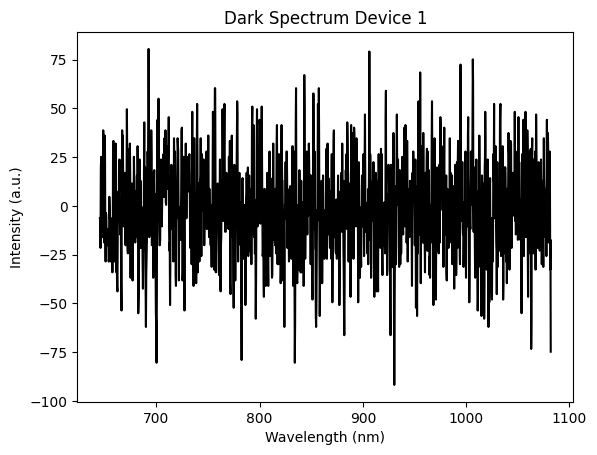

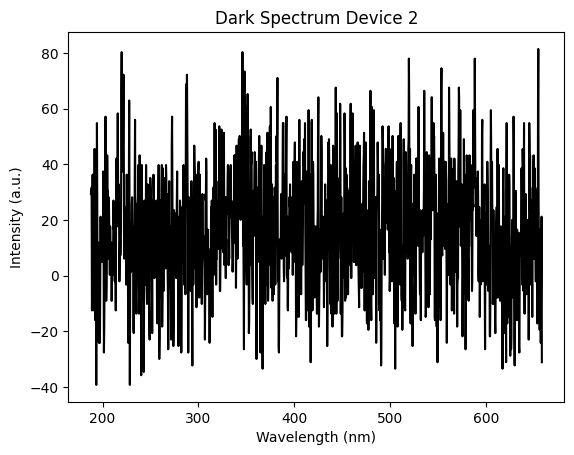

Place white reference and press Enter to record REFERENCE spectra...


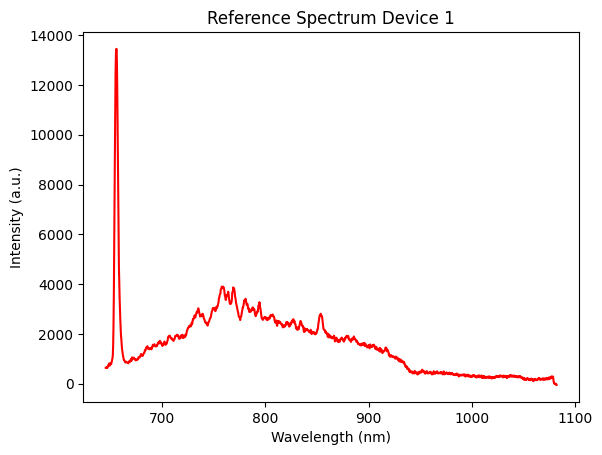

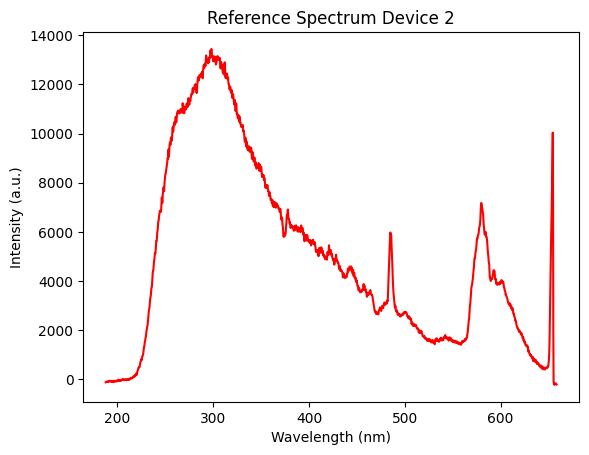

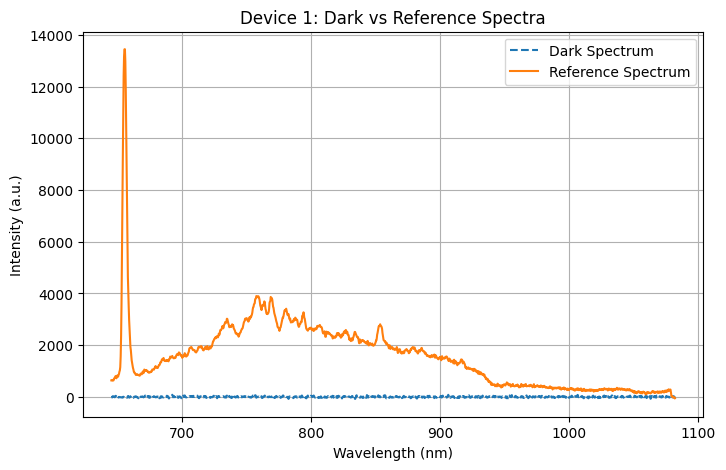

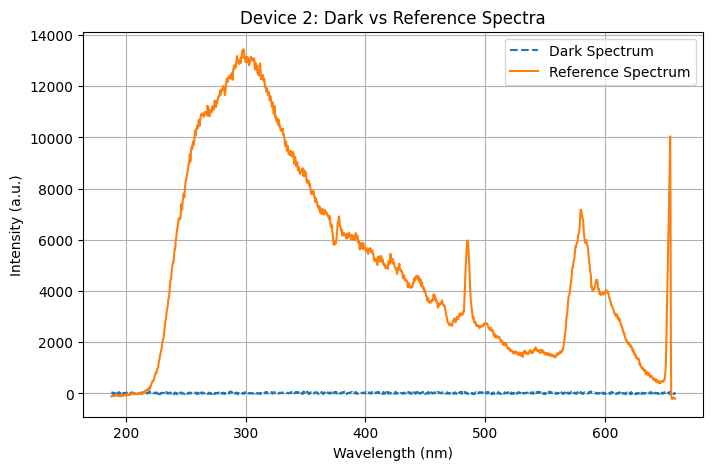

Starting measurement on both devices...
ID	L,A,B	L	A	B	hydrolysis_score	cake_score
FDG250527A-1	48.195,47.211,82.927	48.195	47.211	82.927	0.000	0.000
FDG250527B-1	81.373,23.115,37.732	81.373	23.115	37.732	54.598	22.525
FDG250527A-2	2.235,3.167,2.785	2.235	3.167	2.785	0.650	0.000
FDG250527A-2	81.135,9.843,34.475	81.135	9.843	34.475	68.120	38.817
FDG250527B-2	95.860,1.075,15.800	95.860	1.075	15.800	94.415	80.986
FDG250527C-1	100.088,-0.558,2.299	100.088	-0.558	2.299	101.185	99.231
FDG250527A-3	88.864,3.835,22.868	88.864	3.835	22.868	83.600	64.162
FDG250527A-4	90.948,1.974,18.905	90.948	1.974	18.905	88.138	72.069
D	90.605,2.156,18.893	90.605	2.156	18.893	87.615	71.556
FDG250527A-5	91.644,1.369,17.485	91.644	1.369	17.485	89.653	74.791
FDG250527A-6	92.184,1.066,15.337	92.184	1.066	15.337	90.818	77.781


In [ ]:
# 7. Execute measurements on both devices
wv_list, darks, refs = collect_calibration_spectra()
print("Starting measurement on both devices...")
run_user_measurements(wv_list, darks, refs)

# Cleanup devices
try:
    for idx, d in enumerate(devices, start=1):
        api.close_device(d.get_device_id())
        print(f"Closed device {idx}")
except Exception as e:
    print(f"Error during cleanup: {e}")
